In [43]:
import numpy as np
import math

In [44]:
a_ArAr = 5.311 # argon lattice constant

## Utility functions
1. generate structures (simple cubic and FCC)
2. add perturbation

In [45]:
def gen_simplecubic(nx, ny, nz, lattice_cnst, shiftx = 0, shifty = 0, shiftz = 0):
    return np.array([[i*lattice_cnst+shiftx, j*lattice_cnst+shifty, k*lattice_cnst+shiftz] for i in range(nx) for j in range(ny) for k in range(nz)])

def gen_fcc(nx, ny, nz, lattice_cnst, shiftx = 0, shifty = 0, shiftz = 0):
    return np.array([[[(i+shiftx)*lattice_cnst, (j+shifty)*lattice_cnst, (k+shiftz)*lattice_cnst], 
    [(i+0.5+shiftx)*lattice_cnst, (j+0.5+shifty)*lattice_cnst, (k+shiftz)*lattice_cnst],
    [(i+0.5+shiftx)*lattice_cnst, (j+shifty)*lattice_cnst, (k+0.5+shiftz)*lattice_cnst], 
    [(i+shiftx)*lattice_cnst, (j+0.5+shifty)*lattice_cnst, (k+0.5+shiftz)*lattice_cnst]]for i in range(nx) for j in range(ny) for k in range(nz)]).reshape(-1, 3)

def perturb_cell(cell, strength=0.05):
    return cell + np.random.rand(cell.shape[0], cell.shape[1]) * strength

A test for generation function

In [46]:
dim = 2
cell = gen_fcc(dim,dim,dim,a_ArAr)
cell_vector = np.array([[dim*a_ArAr,0,0], [0,dim*a_ArAr,0], [0,0,dim*a_ArAr]])
cell.shape

(32, 3)

## Utiliies Functions 
1. reciprocal vectors for lattice vectors
2. PBC for distance vectors

In [47]:
def reciprocal_vec(a):
    b = np.empty((3,3))
    vol = np.dot(a[0], np.cross(a[1], a[2]))
    b[0] = np.cross(a[1], a[2]) / vol
    b[1] = np.cross(a[2], a[0]) / vol
    b[2] = np.cross(a[0], a[1]) / vol
    return b

def pbc(d):
    tmp = np.modf(d)[0]
    tmp[tmp > 0.5000001] -= 1
    tmp[tmp < -0.5000001] += 1
    return tmp


A test for riprocal vec and pbc

In [48]:
r_cell_vector = reciprocal_vec(cell_vector)
d = np.array([dim*a_ArAr,11322,-313])
r_trued = pbc(d.dot(r_cell_vector))
trued = r_trued.dot(cell_vector)
d, trued

(array([ 1.0622e+01,  1.1322e+04, -3.1300e+02]),
 array([ 0.   , -1.052, -4.962]))

## Neighbor list function

In [49]:
import pandas as pd
def neighbor_list(xyz, lattice, cutoff=np.Inf):
    nlist = {'atom1':[], 'atom2':[], 'dvec': [], 'r2': []}
    r_lattice = reciprocal_vec(lattice)
    for i in range(len(xyz)):
        for j in range(i+1, len(xyz)):
            d = xyz[j] - xyz[i]
            r_trued = pbc(d.dot(r_lattice))
            trued = r_trued.dot(lattice)
            r2 = trued.dot(trued)
            if r2 < cutoff**2:
                nlist['atom1'].append(i)
                nlist['atom2'].append(j)
                nlist['dvec'].append(trued)
                nlist['r2'].append(r2)
    return nlist

## LJ potenial calculation and LJ first derivative prefactor calculation

In [50]:
pi = 3.141592654
e_0 = 55.26349406 / 1e4 # e^2 eV^-1 Angstrom^-1, vacuum permittivity
eV = 1.602176634e-19

a_ArAr = 5.311 # Angstrom, lattice constant
epsilon_ArAr = 0.0104 # eV, potential params 
sigma_ArAr = 0.34 * 10 # Angstrom, potential params 

En_Ar = -0.08 # eV, reference cohesive energy

def LJ(r2, epsilon, sigma):
    sq_sigma = sigma * sigma
    s_r_6 = (sq_sigma / r2) * (sq_sigma / r2) * (sq_sigma / r2)
    return 4 * epsilon * (s_r_6 * s_r_6 - s_r_6)

def LJ_slope_prefactor(r2, epsilon, sigma):
    sigma2 = sigma * sigma
    s_r_6 = (sigma2 / r2) * (sigma2 / r2) * (sigma2 / r2)
    return 4 * epsilon * (- 12 * s_r_6 * s_r_6 / r2 + 6 * s_r_6 / r2)

## Main Functions 1
1. LJ potential slopes for all atoms
2. Moving all atoms given slopes and rate
3. Secant method for line minimization
4. Solve LJ potential with Steepest Descent

In [51]:
def LJ_Fprime(xyz, lattice):
    nlist_df = pd.DataFrame(neighbor_list(xyz, lattice))
    Fprime = np.zeros((len(xyz), 3))
    pref_df = LJ_slope_prefactor(nlist_df['r2'], epsilon_ArAr, sigma_ArAr)
    for (pref, d, a1, a2) in zip(pref_df, nlist_df['dvec'], nlist_df['atom1'], nlist_df['atom2']):
        Fprime[a1] -= pref * np.array(d)
        Fprime[a2] += pref * np.array(d)
    return Fprime

def nextstep_xyz(xyz, Fprime, rate):
    return np.array([coords + a * -f for (coords, a, f) in zip(xyz, rate, Fprime)])

def secant_method(Fprime, step_Fprime, h, rate, tol=1e-20):
    diff = (step_Fprime - Fprime).dot((step_Fprime - Fprime).T).diagonal()
    frac = Fprime.dot(h.T).diagonal() / (step_Fprime - Fprime).dot(h.T).diagonal()
    alpha = np.array([-a * f for (a, f) in zip(rate, frac)])
    alpha[diff < tol] = 0
    return alpha

def LJ_SD(xyz, lattice, rate):
    Fprime = LJ_Fprime(xyz, lattice)
    step_Fprime = LJ_Fprime(nextstep_xyz(xyz, Fprime, rate=rate), lattice)
    h = -Fprime
    alpha = secant_method(Fprime, step_Fprime, h, rate=rate)
    next_xyz = nextstep_xyz(xyz, Fprime, rate=alpha)
    return alpha, next_xyz

## Write Argon cell into xyz for output / debugging

In [52]:
def write_Arcell(Ar_cell, fname='Arcell.xyz'):
    with open(fname, "w") as file1:
        file1.write(f"{len(Ar_cell)}\n")
        file1.write("\n")
        for i, row in enumerate(Ar_cell):
            atom = "Ar"
            file1.write(f"{atom}\t{row[0]}\t{row[1]}\t{row[2]}\n")
    return

## Perform SD on perturbed 2x2x2 Argon FCC cell

In [62]:
dim = 2
cell = gen_fcc(dim,dim,dim,a_ArAr)
cell = perturb_cell(cell, strength=0.01)
write_Arcell(cell, 'Arcell_before.xyz')
cell_vector = np.array([[dim*a_ArAr,0,0], [0,dim*a_ArAr,0], [0,0,dim*a_ArAr]])
rate = np.ones(len(cell)) * 1e-6

nlist_df = pd.DataFrame(neighbor_list(cell, cell_vector))
all_en = []
all_en.append(sum(LJ(nlist_df['r2'], epsilon_ArAr, sigma_ArAr)))
print('initial energy', all_en[-1])

for i in range(15):
    alpha, next_cell = LJ_SD(cell, cell_vector, rate=rate)
    cell = next_cell
    nlist_df = pd.DataFrame(neighbor_list(cell, cell_vector))
    next_en = sum(LJ(nlist_df['r2'], epsilon_ArAr, sigma_ArAr))
    print('total energy', next_en, 'energy per atom', next_en / len(cell))
    if (abs(next_en - all_en[-1]) < 1e-5):
        print("converged")
        break
    all_en.append(next_en)

write_Arcell(cell, 'Arcell_after.xyz')

initial energy -2.283446571668403
total energy -2.2868474557190557 energy per atom -0.07146398299122049
total energy -2.2877987196922507 energy per atom -0.07149370999038283
total energy -2.2876345967018388 energy per atom -0.07148858114693246
total energy -2.288060218033243 energy per atom -0.07150188181353885
total energy -2.2881509919139815 energy per atom -0.07150471849731192
total energy -2.2881778445610985 energy per atom -0.07150555764253433
total energy -2.2881828011892735 energy per atom -0.0715057125371648
converged


Text(0.5, 1.0, 'Perturbed Ar Cell 2x2x2 (LJ potential + Steepest Descent)')

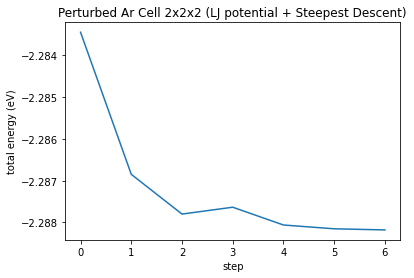

In [63]:
import matplotlib.pyplot as plt
plt.plot(all_en)
plt.ylabel('total energy (eV)')
plt.xlabel('step')
plt.title('Perturbed Ar Cell 2x2x2 (LJ potential + Steepest Descent)')

## CoulombBuckingham potential and slope prefactor

In [55]:
a_MgO = 4.26 # // Angstrom, lattice constant
# const double a_MgO = 1; // Angstrom, lattice constant

A_MgMg = 0# // eV, potential params 
B_MgMg = 1# // Angstrom^-1, potential params 
C_MgMg = 0# // eV Angstrom^6, potential params 

A_MgO = 821.6 # // eV, potential params 
B_MgO = 1. / 0.3242 # // Angstrom^-1, potential params 
C_MgO = 0 # // eV Angstrom^6, potential params

A_OO = 22764. # // eV, potential params 
B_OO = 1. / 0.149 # // Angstrom^-1, potential params 
C_OO = 27.88 # // eV Angstrom^6, potential params 

q_Mg = 2 # // e, Mg 2+ ion charge
q_O = -2 # // e, O 2- ion charge

En_MgO = -20.1 # // eV, reference binding energy

def CoulombBuckingham(r2, q1, q2, A, B, C):
    r = np.sqrt(r2)
    return (A * np.exp(-B * r)) - (C / (r2 * r2 * r2)) + ((q1 * q2) / (4 * pi * e_0 * r))

def CoulombBuckingham_slope_prefactor(r2, q1, q2, A, B, C):
    r = np.sqrt(r2)
    return (-A * B * np.exp(-B * r) / r) + (6 * C / (r2 * r2 * r2 * r2)) - (q1 * q2 / (4 * pi * e_0 * r2 * r))

## Main Functions 2
1. Total energy of CoulombBuckingham potential given neighbour list
2. CoulombBuckingham potential slopes for all atoms
3. Solve CoulombBuckingham potential with Conjugate Gradient Descent

In [56]:
def total_CoulombBuckingham(nlist_df, length):
    en_tot = 0
    tmp_r2 = nlist_df.loc[((nlist_df['atom1'] < length) & (nlist_df['atom2'] < length)), 'r2']
    en_tot += sum(CoulombBuckingham(tmp_r2, q_Mg, q_Mg, A_MgMg, B_MgMg, C_MgMg))
    tmp_r2 = nlist_df.loc[((nlist_df['atom1'] >= length) & (nlist_df['atom2'] >= length)), 'r2']
    en_tot += sum(CoulombBuckingham(tmp_r2, q_O, q_O, A_OO, B_OO, C_OO))
    tmp_r2 = nlist_df.loc[((nlist_df['atom1'] < length) & (nlist_df['atom2'] >= length)), 'r2']
    en_tot += sum(CoulombBuckingham(tmp_r2, q_Mg, q_O, A_MgO, B_MgO, C_MgO))
    tmp_r2 = nlist_df.loc[((nlist_df['atom1'] >= length) & (nlist_df['atom2'] < length)), 'r2']
    en_tot += sum(CoulombBuckingham(tmp_r2, q_Mg, q_O, A_MgO, B_MgO, C_MgO))
    return en_tot

def CoulombBuckingham_Fprime(xyz, lattice, length):
    nlist_df = pd.DataFrame(neighbor_list(xyz, lattice))
    Fprime = np.zeros((len(xyz), 3))
    
    nlist_df['pref'] = 0
    tmp_r2 = nlist_df.loc[((nlist_df['atom1'] < length) & (nlist_df['atom2'] < length)), 'r2']
    nlist_df.loc[((nlist_df['atom1'] < length) & (nlist_df['atom2'] < length)), 'pref'] = CoulombBuckingham_slope_prefactor(tmp_r2, q_Mg, q_Mg, A_MgMg, B_MgMg, C_MgMg)

    tmp_r2 = nlist_df.loc[((nlist_df['atom1'] >= length) & (nlist_df['atom2'] >= length)), 'r2']
    nlist_df.loc[((nlist_df['atom1'] >= length) & (nlist_df['atom2'] >= length)), 'pref'] = CoulombBuckingham_slope_prefactor(tmp_r2, q_O, q_O, A_OO, B_OO, C_OO)

    tmp_r2 = nlist_df.loc[((nlist_df['atom1'] < length) & (nlist_df['atom2'] >= length)), 'r2']
    nlist_df.loc[((nlist_df['atom1'] < length) & (nlist_df['atom2'] >= length)), 'pref'] = CoulombBuckingham_slope_prefactor(tmp_r2, q_Mg, q_O, A_MgO, B_MgO, C_MgO)

    tmp_r2 = nlist_df.loc[((nlist_df['atom1'] >= length) & (nlist_df['atom2'] < length)), 'r2']
    nlist_df.loc[((nlist_df['atom1'] >= length) & (nlist_df['atom2'] < length)), 'pref'] = CoulombBuckingham_slope_prefactor(tmp_r2, q_Mg, q_O, A_MgO, B_MgO, C_MgO)
    
    for (pref, d, a1, a2) in zip(nlist_df['pref'], nlist_df['dvec'], nlist_df['atom1'], nlist_df['atom2']):
        Fprime[a1] -= pref * np.array(d)
        Fprime[a2] += pref * np.array(d)
    return Fprime

def CoulombBuckingham_CG(xyz, lattice, rate, h, length):
    Fprime = CoulombBuckingham_Fprime(xyz, lattice, length)
    step_Fprime = CoulombBuckingham_Fprime(nextstep_xyz(xyz, Fprime, rate=rate), lattice, length)

    alpha = secant_method(Fprime, step_Fprime, h, rate=rate, tol=1e-7)
    next_xyz = nextstep_xyz(xyz, Fprime, rate=alpha)

    new_Fprime = CoulombBuckingham_Fprime(next_xyz, lattice, length)
    gamma = Fprime.dot(Fprime.T).diagonal() / new_Fprime.dot(new_Fprime.T).diagonal()
    next_h = np.array([-f + ga * h_prev for (f, ga, h_prev) in zip(new_Fprime, gamma, h)])
    return next_xyz, next_h
    

## Write MgO cell into xyz for output / debugging

In [57]:
def write_MgOcell(MgO_cell, length, fname='MgOcell.xyz'):
    with open(fname, "w") as file1:
        file1.write(f"{len(MgO_cell)}\n")
        file1.write("\n")
        for i, row in enumerate(MgO_cell):
            atom = "Mg" if i < length else "O"
            file1.write(f"{atom}\t{row[0]}\t{row[1]}\t{row[2]}\n")
    return

## Perform CGD on perturbed 2x2x2 MgO FCC cell

In [58]:
dim = 2
MgO_cell = gen_fcc(dim, dim, dim, a_MgO)
Mg_length = len(MgO_cell)
O_cell = gen_fcc(dim, dim, dim, a_MgO, 0.5)
MgO_cell = np.append(MgO_cell, O_cell, axis=0)

MgO_cell = perturb_cell(MgO_cell, strength=0.01)
MgO_cell_vector = np.array([[dim*a_MgO,0,0], [0,dim*a_MgO,0], [0,0,dim*a_MgO]])
write_MgOcell(MgO_cell, Mg_length, 'MgOcell_before.xyz')

rate = np.ones(len(MgO_cell)) * 1e-6
h = - CoulombBuckingham_Fprime(MgO_cell, MgO_cell_vector, Mg_length)

nlist_df = pd.DataFrame(neighbor_list(MgO_cell, MgO_cell_vector))
all_en = []
all_en.append(total_CoulombBuckingham(nlist_df, length=Mg_length))
print('initial energy', all_en[-1])
for i in range(15):
    MgO_cell_next, h_next = CoulombBuckingham_CG(MgO_cell, MgO_cell_vector, rate, h, Mg_length)
    MgO_cell = MgO_cell_next
    h = h_next
    
    nlist_df = pd.DataFrame(neighbor_list(MgO_cell, MgO_cell_vector))
    next_en = total_CoulombBuckingham(nlist_df, length=Mg_length)
    print('total energy', next_en, 'energy per atom', next_en / len(MgO_cell))
    if (abs(next_en - all_en[-1]) < 1e-3):
        print("converged")
        break
    all_en.append(next_en)
write_MgOcell(MgO_cell, Mg_length, 'MgOcell_after.xyz')

initial energy -1299.584024953836
total energy -956.4607847207371 energy per atom -14.944699761261518
total energy -827.4365143817031 energy per atom -12.92869553721411
total energy -846.5052665461662 energy per atom -13.226644789783848
total energy -653.3690044543782 energy per atom -10.20889069459966
total energy -549.5840225298798 energy per atom -8.587250352029372
total energy -577.3905728075715 energy per atom -9.021727700118305
total energy -695.5937453597035 energy per atom -10.868652271245367
total energy -749.4584635349893 energy per atom -11.710288492734207
total energy -679.7973279108555 energy per atom -10.621833248607118
total energy -693.8193456896079 energy per atom -10.840927276400123
total energy -1329.889615062697 energy per atom -20.77952523535464
total energy -954.6916943377128 energy per atom -14.917057724026762
total energy -781.9049558475126 energy per atom -12.217264935117385
total energy -635.2285624079486 energy per atom -9.925446287624197
total energy -540.81

Text(0.5, 1.0, 'Perturbed MgO Cell 2x2x2 (CoulombBuckingham potential + Conjugate Descent)')

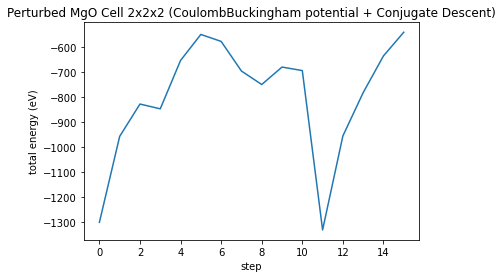

In [59]:
plt.plot(all_en)
plt.ylabel('total energy (eV)')
plt.xlabel('step')
plt.title('Perturbed MgO Cell 2x2x2 (CoulombBuckingham potential + Conjugate Descent)')